In [18]:
# To download the data:

# https://paleobiodb.org/data1.2/occs/list.csv?datainfo%26rowcount%26max_ma%3D1000%26min_ma%3D0%26show%3Dclass,coll,coords,loc,paleoloc,stratext,env&sa=D&source=hangouts&ust=1647440642700000&usg=AOvVaw2UtFUtdBM4CEWUj17F5AaL
# There's a bunch of lead-up lines in the file which should be removed, leaving only the first line of headers

FILENAME = "/sata/data/fossil/pbdb_data.csv"

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from math import *
import time

from IPython import display

from sklearn.preprocessing import LabelEncoder

In [219]:
data.columns

Index(['occurrence_no', 'record_type', 'reid_no', 'flags', 'collection_no',
       'identified_name', 'identified_rank', 'identified_no', 'difference',
       'accepted_name', 'accepted_rank', 'accepted_no', 'early_interval',
       'late_interval', 'max_ma', 'min_ma', 'reference_no', 'phylum', 'class',
       'order', 'family', 'genus', 'collection_name', 'collection_subset',
       'collection_aka', 'lng', 'lat', 'cc', 'state', 'county', 'latlng_basis',
       'latlng_precision', 'geogscale', 'geogcomments', 'paleomodel',
       'paleolng', 'paleolat', 'geoplate', 'formation', 'stratgroup', 'member',
       'stratscale', 'zone', 'localsection', 'localbed', 'localorder',
       'regionalsection', 'regionalbed', 'regionalorder', 'stratcomments',
       'environment'],
      dtype='object')

In [52]:
data = pd.read_csv(FILENAME)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (37,44,46,47,48) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [86]:
pd.unique(data['environment']).shape

(75,)

In [160]:
data = data[pd.notna(data['phylum'])]
data = data[pd.notna(data['class'])]
data = data[pd.notna(data['environment'])]

In [161]:
data.shape

(1436644, 51)

In [162]:
phyla = pd.unique(data['phylum']).tolist()
phylum_le = LabelEncoder()
phylum_le.fit(phyla)

classes = pd.unique(data['class']).tolist()
classes_le = LabelEncoder()
classes_le.fit(classes)

envs = pd.unique(data['environment']).tolist()
envs_le = LabelEncoder()
envs_le.fit(envs)

LabelEncoder()

In [76]:
cphyla = ["" for i in range(len(classes_le.classes_))]

for c in classes:
    cdata = data[data['class']==c]
    cidx = classes_le.transform(np.array([c]))[0]
    cphyla[cidx] = phylum_le.transform(np.array(cdata['phylum'].iloc[0:1]))[0]

In [77]:
cphyla

[15,
 15,
 40,
 42,
 15,
 42,
 1,
 4,
 18,
 5,
 48,
 56,
 1,
 15,
 24,
 15,
 46,
 77,
 68,
 40,
 5,
 8,
 14,
 26,
 56,
 59,
 24,
 5,
 40,
 14,
 7,
 5,
 14,
 15,
 42,
 24,
 5,
 15,
 75,
 3,
 32,
 15,
 59,
 5,
 15,
 18,
 24,
 7,
 59,
 24,
 24,
 18,
 21,
 22,
 23,
 24,
 24,
 14,
 56,
 2,
 46,
 48,
 5,
 42,
 24,
 24,
 24,
 43,
 33,
 24,
 26,
 15,
 42,
 73,
 67,
 15,
 40,
 29,
 28,
 30,
 9,
 75,
 75,
 40,
 24,
 8,
 56,
 73,
 56,
 5,
 24,
 24,
 18,
 18,
 34,
 42,
 5,
 5,
 56,
 8,
 7,
 42,
 31,
 35,
 39,
 7,
 63,
 71,
 5,
 15,
 42,
 8,
 46,
 18,
 5,
 5,
 40,
 8,
 5,
 21,
 42,
 5,
 28,
 7,
 24,
 24,
 15,
 34,
 15,
 15,
 5,
 42,
 24,
 40,
 7,
 5,
 48,
 15,
 46,
 53,
 15,
 3,
 16,
 40,
 21,
 75,
 12,
 62,
 63,
 15,
 15,
 63,
 31,
 33,
 63,
 5,
 42,
 42,
 56,
 5,
 15,
 42,
 42,
 67,
 24,
 7,
 75,
 40,
 15,
 40,
 56,
 5,
 18,
 42,
 24,
 24,
 50,
 72,
 9,
 40,
 24,
 56,
 7,
 24,
 5,
 53,
 36,
 42,
 40,
 11,
 5,
 5,
 54,
 5,
 28,
 54,
 14,
 42,
 77,
 53,
 42,
 5,
 78]

In [222]:
phylum_origins = np.zeros((len(phylum_le.classes_), 201))
phylum_extinctions = np.zeros((len(phylum_le.classes_), 201))
class_origins = np.zeros((len(classes_le.classes_), 201))
class_extinctions = np.zeros((len(classes_le.classes_), 201))

envs_origins = np.zeros((len(envs_le.classes_), 201))
envs_extinctions = np.zeros((len(envs_le.classes_), 201))

plabels = phylum_le.transform(data['phylum'])
clabels = classes_le.transform(data['class'])
elabels = envs_le.transform(data['environment'])

class_lat = np.zeros((len(classes_le.classes_,)))
class_count = np.zeros((len(classes_le.classes_,)))
class_lng = np.zeros((len(classes_le.classes_,)))

for i in range(data.shape[0]):
    p = plabels[i]
    c = clabels[i]
    e = elabels[i]
    
    origin = data['max_ma'].iloc[i]/5
    extinction = data['min_ma'].iloc[i]/5
    lat = data['lat'].iloc[i]
    lng = data['lng'].iloc[i]
    
    phylum_origins[p,int(origin)] += 1
    phylum_extinctions[p,int(extinction)] += 1
    
    class_origins[c,int(origin)] += 1
    class_extinctions[c,int(extinction)] += 1    
    class_lat[c] += lat
    class_lng[c] += lng
    class_count[c] += 1
    
    envs_origins[e,int(origin)] += 1
    envs_extinctions[e,int(extinction)] += 1        
    
class_lat /= class_count
class_lng /= class_count

In [165]:
class_time = np.sum(class_extinctions * np.arange(201).reshape((1,201)) / np.sum(class_extinctions, axis=1, keepdims=True), axis=1)
phylum_time = np.sum(phylum_extinctions * np.arange(201).reshape((1,201)) / np.sum(phylum_extinctions, axis=1, keepdims=True), axis=1)
env_time = np.sum(envs_extinctions * np.arange(201).reshape((1,201)) / np.sum(envs_extinctions, axis=1, keepdims=True), axis=1)

(array([ 8., 18., 23., 37., 56., 31.,  7.,  7., 11.,  4.]),
 array([-120.18306  ,  -93.5530871,  -66.9231142,  -40.2931413,
         -13.6631684,   12.9668045,   39.5967774,   66.2267503,
          92.8567232,  119.4866961,  146.116669 ]),
 <BarContainer object of 10 artists>)

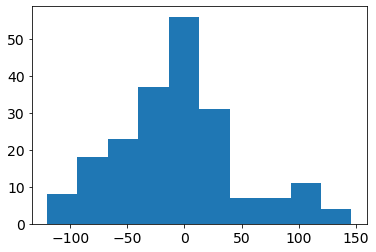

In [225]:
plt.hist(class_lng)

In [330]:
def kldiv(p,q): # axis 2 is the distribution, 0 and 1 are batch dimensions
    return torch.sum(p*torch.log(p/(q+1e-16) + 1e-16), 2)

def jsd(p,q):
    p = p/torch.sum(p,2).unsqueeze(2)
    q = q/torch.sum(q,2).unsqueeze(2)
    
    m = (p+q)/2
    
    return 0.5*(kldiv(p,m) + kldiv(q,m))

def local_norm_distance(p,q):
    d = 0
    
    for i in range(5,p.shape[2]-5):
        avg_p = torch.sum(p[:,:,i-5:i+5],2)+1e-2
        avg_q = torch.sum(q[:,:,i-5:i+5],2)+1e-2
        d += (p[:,:,i]/avg_p - q[:,:,i]/avg_q)**2
    
    return d

class Embedding(nn.Module):
    def __init__(self, N, DIM=2):
        super().__init__()
        self.embeddings = torch.nn.Parameter(torch.randn(N, DIM))
        
    def loss(self, matrix):
        embedding_distances = torch.sqrt(1e-8 + torch.sum( (self.embeddings.unsqueeze(0)-self.embeddings.unsqueeze(1))**2, 2))
                
        target_distances = local_norm_distance(matrix.unsqueeze(0), matrix.unsqueeze(1))
        
        return torch.mean(torch.abs(target_distances - embedding_distances))

In [226]:
embed = Embedding(len(classes_le.classes_), 2).cuda()
optim = torch.optim.Adam(embed.parameters(), lr=1e-2)

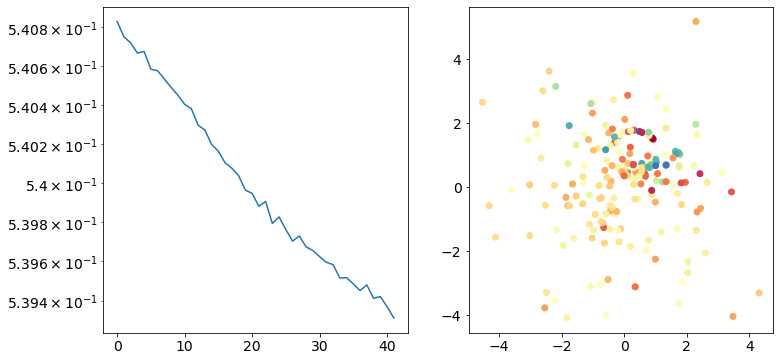

KeyboardInterrupt: 

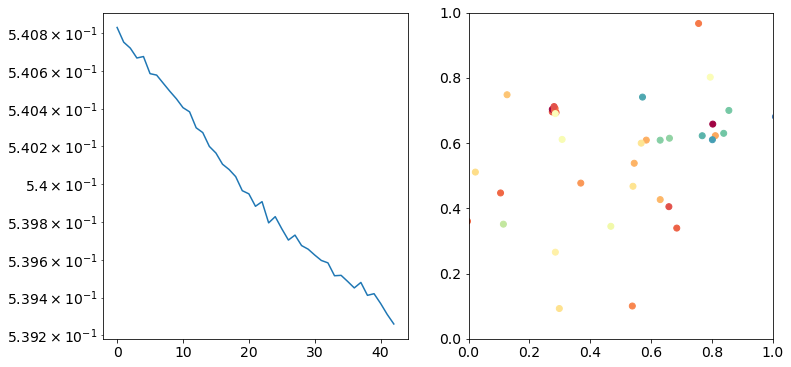

In [228]:
tr_loss = []

for p in optim.param_groups:
    p['lr'] = 1e-1
    
for epoch in range(100000):
    optim.zero_grad()
    loss = embed.loss(torch.cuda.FloatTensor(class_extinctions))
    loss.backward()
    optim.step()
    
    tr_loss.append(loss.cpu().detach().item())
    
    plt.clf()
    plt.subplot(1,2,1)
    plt.plot(tr_loss)
    plt.yscale("log")
    
    plt.subplot(1,2,2)
    z = embed.embeddings.cpu().detach().numpy()
    
    plt.scatter(z[:,0], z[:,1], c=class_lng, cmap=plt.cm.Spectral)
    
    plt.gcf().set_size_inches((12,6))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.01)

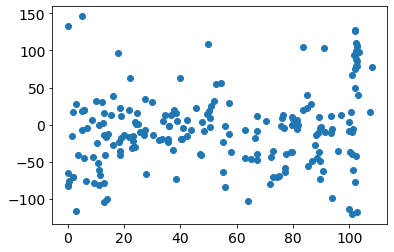

In [229]:
plt.scatter(class_time, class_lng)

In [247]:
class_lng_dist = []

for c in classes_le.classes_:
    cdata = data[data['class']==c]
    bars, xpos = np.histogram(np.array(cdata['lng']), range=[-180, 180], bins=40)
    class_lng_dist.append(bars)

In [248]:
np.array(class_lng_dist).shape

(202, 40)

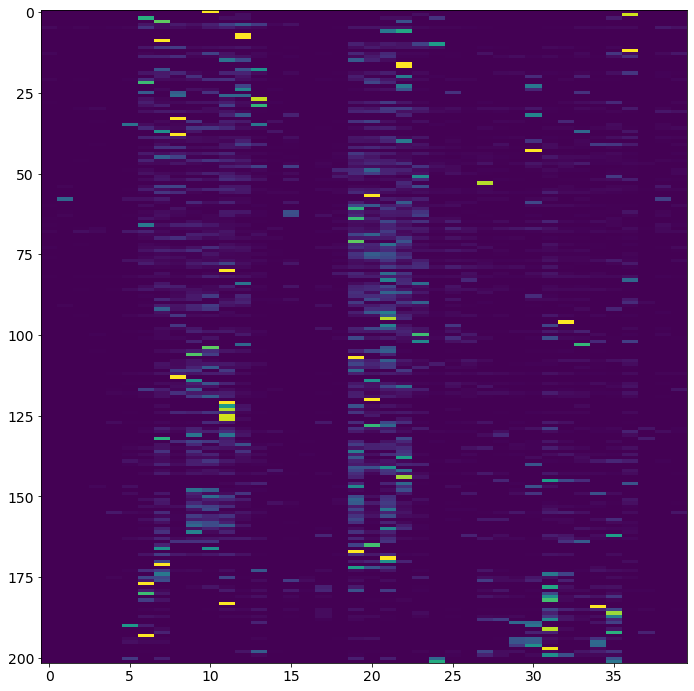

In [250]:
sorted_dists = np.array(class_lng_dist)[np.argsort(class_time)]
sorted_dists = sorted_dists/np.sum(sorted_dists, axis=1, keepdims=True)
plt.imshow(sorted_dists, aspect=0.2)
plt.gcf().set_size_inches((12,12))
plt.show()

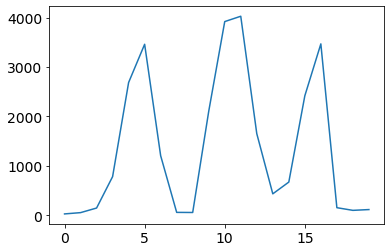

In [242]:
plt.plot(class_lng_dist[129])

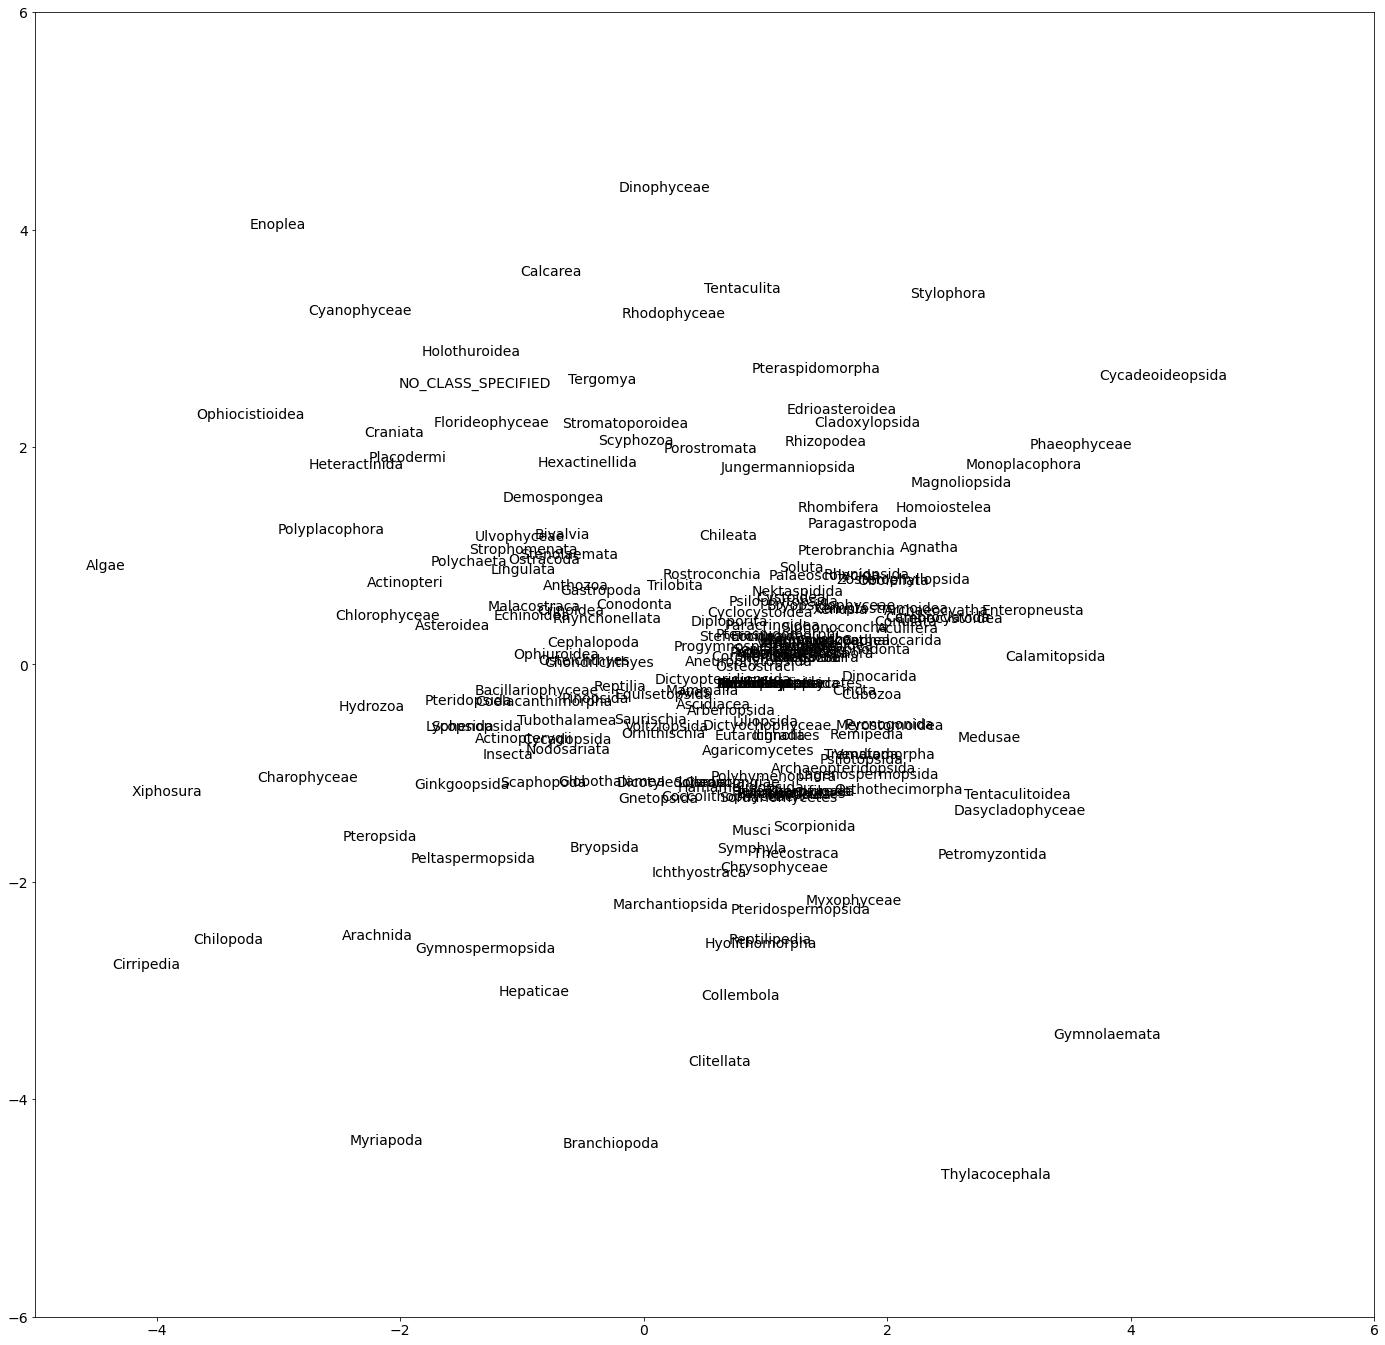

In [218]:
plt.rcParams['font.size'] = 14

for i in range(len(classes_le.classes_)):
    if 'phyta' in classes_le.classes_[i]:
        plt.text(z[i,0], z[i,1], classes_le.classes_[i], color='red')
    else:
        plt.text(z[i,0], z[i,1], classes_le.classes_[i])

plt.xlim(-5,6)
plt.ylim(-6,6)
plt.gcf().set_size_inches((24,24))
plt.show()

In [331]:
matrix = torch.cuda.FloatTensor(phylum_origins)

target_distances = local_norm_distance(matrix.unsqueeze(0), matrix.unsqueeze(1)).cpu().detach().numpy()

matrix = torch.cuda.FloatTensor(phylum_extinctions)

extinct_distances = local_norm_distance(matrix.unsqueeze(0), matrix.unsqueeze(1)).cpu().detach().numpy()

(array([15]),)


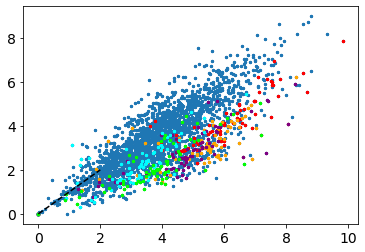

In [332]:
print(np.where(phylum_le.classes_ == "Chordata"))

plt.scatter(target_distances.ravel(), extinct_distances.ravel(), s=5)
#plt.scatter(target_distances[15,:].ravel(), extinct_distances[15,:].ravel(), s=5, c='r')
#plt.scatter(target_distances[:,15].ravel(), extinct_distances[:,15].ravel(), s=5, c='r')
plt.plot(np.arange(3), np.arange(3), c='k', ls='--')

plt.scatter(target_distances[35,:].ravel(), extinct_distances[35,:].ravel(), s=5, c='r')
plt.scatter(target_distances[:,35].ravel(), extinct_distances[:,35].ravel(), s=5, c='r')
plt.scatter(target_distances[58,:].ravel(), extinct_distances[58,:].ravel(), s=5, c='orange')
plt.scatter(target_distances[:,58].ravel(), extinct_distances[:,58].ravel(), s=5, c='orange')
plt.scatter(target_distances[23,:].ravel(), extinct_distances[23,:].ravel(), s=5, c='purple')
plt.scatter(target_distances[:,23].ravel(), extinct_distances[:,23].ravel(), s=5, c='purple')
plt.scatter(target_distances[39,:].ravel(), extinct_distances[39,:].ravel(), s=5, c='cyan')
plt.scatter(target_distances[:,39].ravel(), extinct_distances[:,39].ravel(), s=5, c='cyan')
plt.scatter(target_distances[52,:].ravel(), extinct_distances[52,:].ravel(), s=5, c='lime')
plt.scatter(target_distances[:,52].ravel(), extinct_distances[:,52].ravel(), s=5, c='lime')

plt.show()

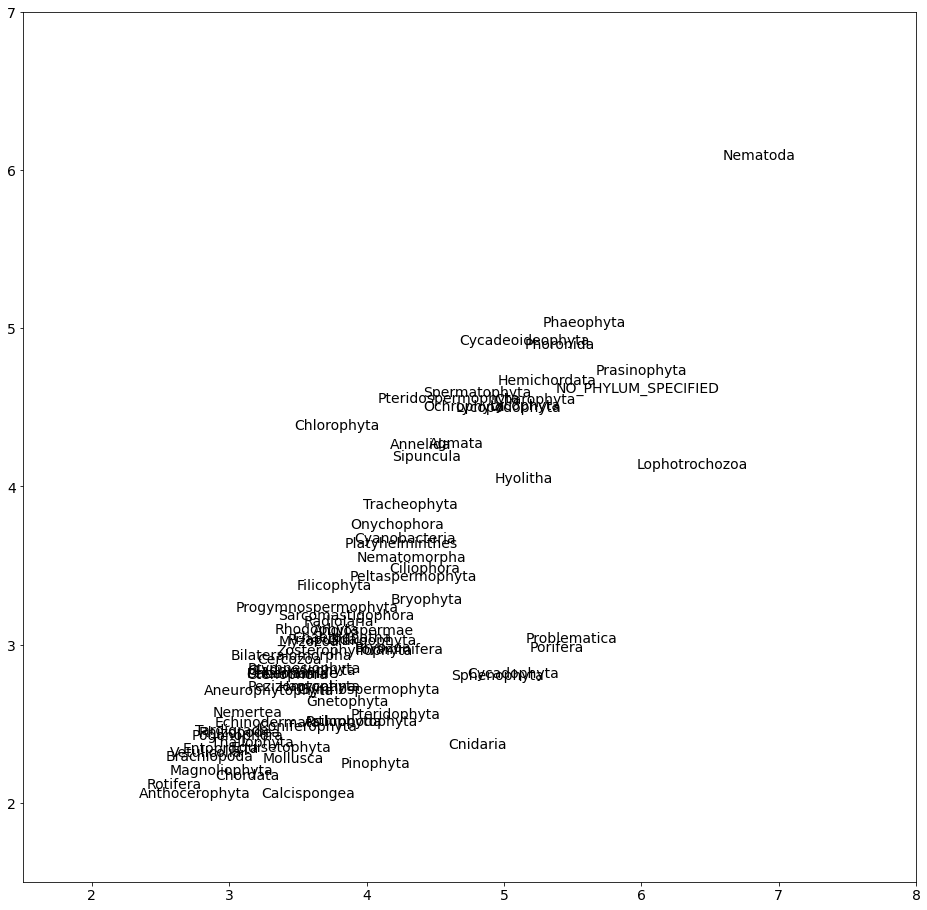

In [334]:
pts = []

for i in range(len(phylum_le.classes_)):
    p = np.concatenate([target_distances[i,:].ravel()[:,np.newaxis], extinct_distances[i,:].ravel()[:,np.newaxis]], axis=1)
    pts.append(np.mean(p, axis=0))

pts = np.array(pts)

for i in range(pts.shape[0]):
    plt.text(pts[i,0], pts[i,1], phylum_le.classes_[i])
plt.xlim(1.5,8)
plt.ylim(1.5,7)
#plt.xlim(0.5,5.5)
#plt.ylim(0.5,5.5)
plt.gcf().set_size_inches((16,16))
plt.show()


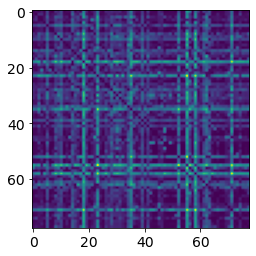

In [275]:
plt.imshow(np.abs(target_distances - extinct_distances))

In [253]:
#idx = np.argsort(class_time)

#target_distances = target_distances[idx,:]
#target_distances = target_distances[:,idx]

In [254]:
target_distances

array([[0.       , 0.       , 0.       , ..., 0.7140617, 1.8134911,
        0.9984633],
       [0.       , 0.       , 0.       , ..., 0.7140617, 1.8134911,
        0.9984633],
       [0.       , 0.       , 0.       , ..., 0.7140617, 1.8134911,
        0.9984633],
       ...,
       [0.7140617, 0.7140617, 0.7140617, ..., 0.       , 2.385001 ,
        1.7125249],
       [1.8134911, 1.8134911, 1.8134911, ..., 2.385001 , 0.       ,
        0.9968204],
       [0.9984633, 0.9984633, 0.9984633, ..., 1.7125249, 0.9968204,
        0.       ]], dtype=float32)

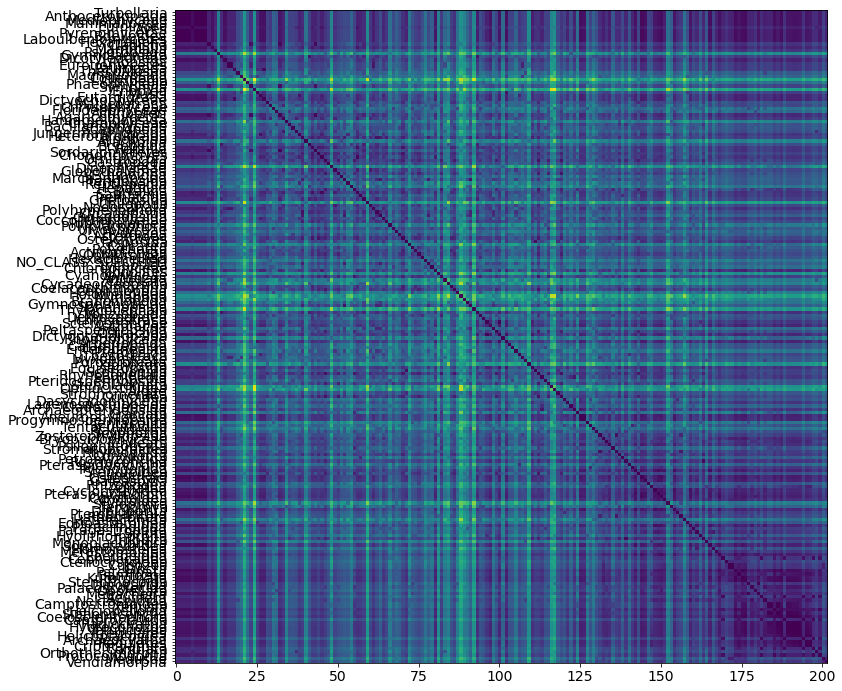

In [255]:
plt.imshow(target_distances, interpolation='nearest')
plt.gcf().set_size_inches((12,12))
plt.yticks(np.arange(len(classes_le.classes_)), classes_le.classes_[idx])
plt.show()

In [258]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

In [276]:
targ = np.abs(target_distances - extinct_distances)
link = linkage(squareform(0.5*(targ+targ.transpose(1,0))))

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [65.0, 65.0, 75.0, 75.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [165.0, 165.0, 175.0, 175.0],
  [195.0, 195.0, 205.0, 205.0],
  [215.0, 215.0, 225.0, 225.0],
  [235.0, 235.0, 245.0, 245.0],
  [265.0, 265.0, 275.0, 275.0],
  [295.0, 295.0, 305.0, 305.0],
  [355.0, 355.0, 365.0, 365.0],
  [375.0, 375.0, 385.0, 385.0],
  [360.0, 360.0, 380.0, 380.0],
  [405.0, 405.0, 415.0, 415.0],
  [395.0, 395.0, 410.0, 410.0],
  [675.0, 675.0, 685.0, 685.0],
  [665.0, 665.0, 680.0, 680.0],
  [655.0, 655.0, 672.5, 672.5],
  [645.0, 645.0, 663.75, 663.75],
  [635.0, 635.0, 654.375, 654.375],
  [625.0, 625.0, 644.6875, 644.6875],
  [615.0, 615.0, 634.84375, 634.84375],
  [605.0, 605.0, 624.921875, 624.921875],
  [595.0, 595.0, 614.9609375, 614.9609375],
  [585.0, 585.0, 604.98046875, 604.98046875],
  [575.0, 575.0, 594.990234375, 594.990234375],
  [565.0, 565.0, 584.9951171875, 584.9951171875],
  [555.0, 555.0, 574.99755859375, 574.997558

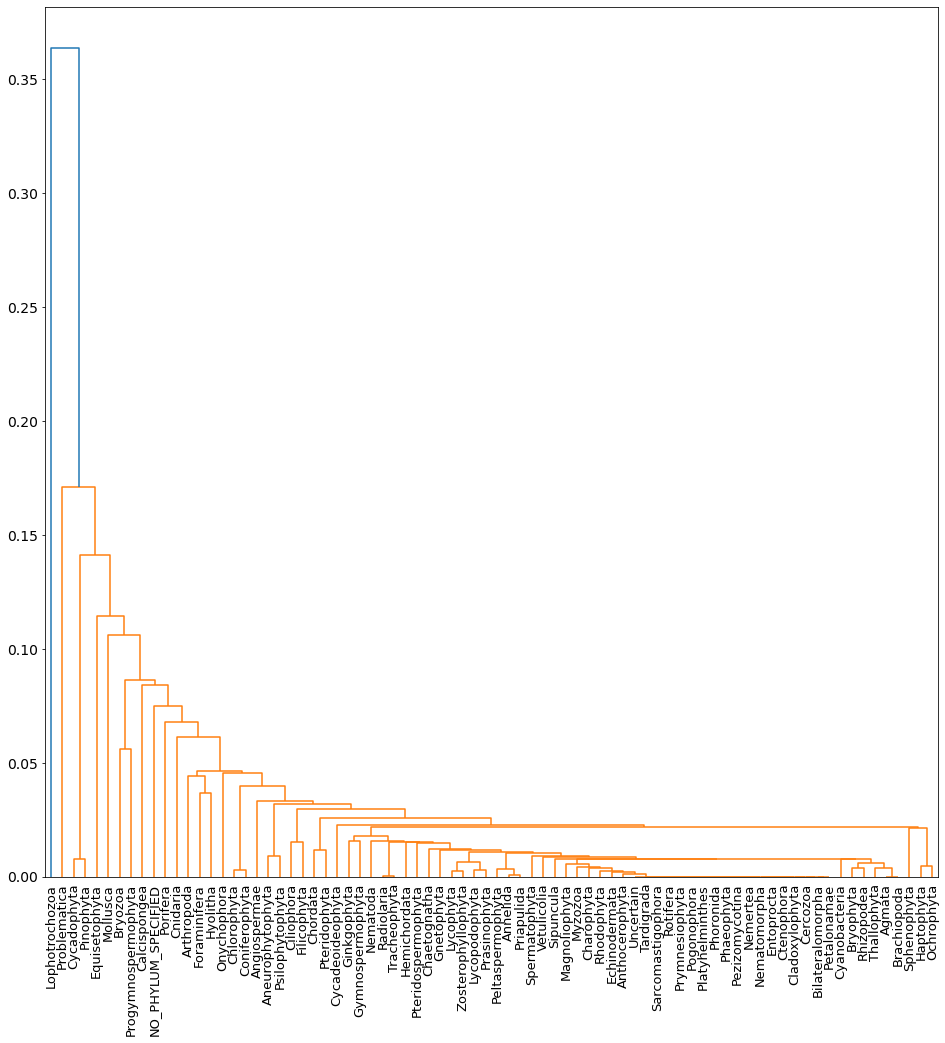

In [277]:
plt.gcf().set_size_inches((16,16))
dendrogram(link, labels = phylum_le.classes_, leaf_font_size = 13)